## Setup

In [3]:
import requests
import zipfile
import io
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pytz
import numpy as np
import pandas as pd
import math
import warnings
import seaborn as sns
import os
import shutil
import re

from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from tqdm import tqdm

# Suppress specific warnings (in this case, FutureWarnings)
warnings.simplefilter(action='ignore', category=FutureWarning)

## Download dataset

In [4]:
# Data from https://archive.ics.uci.edu/dataset/502/online+retail+ii
DATASET_URL = 'https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip'
DATASET_FILENAME = 'online_retail_II.xlsx'

response = requests.get(DATASET_URL)
zip_bytes = io.BytesIO(response.content)

with zipfile.ZipFile(zip_bytes) as z:
    with z.open(DATASET_FILENAME) as file:
        online_retail_df = pd.read_excel(file)

online_retail_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


## Clean data

In [6]:
def normalize(text):
    if pd.isnull(text):
        return np.nan
    text = text.lower()  # lowercase
    text = re.sub(r'[^a-z0-9\s]', '', text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

In [16]:
cleaned_online_retail_df = online_retail_df.copy()

cleaned_online_retail_df = cleaned_online_retail_df[[
    'InvoiceDate',
    'StockCode',
    'Description',
    'Quantity',
    'Price',
]]
cleaned_online_retail_df = cleaned_online_retail_df.query('Quantity > 0')
cleaned_online_retail_df.loc[:,'Description'] = cleaned_online_retail_df['Description'].astype(str).apply(normalize)
cleaned_online_retail_df.loc[:,'StockCode'] = cleaned_online_retail_df['StockCode'].astype(str).str.upper()

cleaned_online_retail_df = cleaned_online_retail_df.dropna(axis=0)

description_exclusion_list = {
    '?',
    'checked',
    'found',
    'mailout',
    'temp',
    'update',
    'damaged',
    'amazon',
    'amazon adjustment',
    'amendment',
    'this is a test product',
    'temp',
    'postage',
    'dotcom postage',
    'manual',
    'carriage',
    '',
}

description_exclusion_mask = ~cleaned_online_retail_df['Description'].isin(description_exclusion_list)

cleaned_online_retail_df = cleaned_online_retail_df[description_exclusion_mask]

cleaned_online_retail_df

,InvoiceDate,StockCode,Description,Quantity,Price
0,2009-12-01 07:45:00,85048,15cm christmas glass ball 20 lights,12,6.95
1,2009-12-01 07:45:00,79323P,pink cherry lights,12,6.75
2,2009-12-01 07:45:00,79323W,white cherry lights,12,6.75
3,2009-12-01 07:45:00,22041,record frame 7 single size,48,2.10
4,2009-12-01 07:45:00,21232,strawberry ceramic trinket box,24,1.25
...,...,...,...,...,...
525456,2010-12-09 20:01:00,22271,feltcraft doll rosie,2,2.95
525457,2010-12-09 20:01:00,22750,feltcraft princess lola doll,1,3.75
525458,2010-12-09 20:01:00,22751,feltcraft princess olivia doll,1,3.75
525459,2010-12-09 20:01:00,20970,pink floral feltcraft shoulder bag,2,3.75


In [10]:
# Create a mapping of original to canonical names
canonical = {}
threshold = 85  # similarity score threshold

for item in tqdm(cleaned_online_retail_df['Description'].unique()):
    matched = None
    for key in canonical:
        if fuzz.ratio(item, key) >= threshold:
            matched = key
            break
    if matched:
        canonical[item] = matched
    else:
        canonical[item] = item

canonical = {key: canonical[key] for key in canonical if key != canonical[key]}

for key in canonical:
    print(f'{key} => {canonical[key]}')

100%|███████████████████████████████████████| 4468/4468 [05:30<00:00, 13.50it/s]

home building block word => love building block word
bath building block word => home building block word
feltcraft doll maria => feltcraft doll rosie
feltcraft doll emily => feltcraft doll maria
charlie lola blue hot water bottle => charlielola red hot water bottle
charlielola pink hot water bottle => charlielola red hot water bottle
charlie lola red hot water bottle => charlielola red hot water bottle
carrot charlielola coaster set => tomato charlielola coaster set
charlie lola wastepaper bin flora => charlie lola wastepaper bin blue
kings choice giant tube matches => kings choice small tube matches
blue felt hanging heart w flower => pink felt hanging heart w flower
set6 woodland paper plates => set6 woodland paper cups
red hanging heart tlight holder => hanging heart zinc tlight holder
feltcraft doll molly => feltcraft doll emily
girls alphabet iron on patches => boys alphabet iron on patches
red stripe ceramic drawer knob => red spot ceramic drawer knob
blue stripe ceramic drawer 

In [17]:
cleaned_online_retail_df.loc[:,'FuzzedDescription'] = cleaned_online_retail_df['Description'].replace(canonical)

cleaned_online_retail_df = cleaned_online_retail_df.set_index('InvoiceDate')

cleaned_online_retail_df = cleaned_online_retail_df.groupby(by=[
    pd.Grouper(freq='D'),  # resample to daily
    'FuzzedDescription',
]).agg({
    'Description': ['unique', 'nunique'],
    'StockCode': ['unique', 'nunique'],
    'Quantity': 'sum',
    'Price': 'mean', 
})

cleaned_online_retail_df.columns = [
    f"{col[0]}_{col[1]}" if col[1] else col[0]
    for col in cleaned_online_retail_df.columns.values
]

cleaned_online_retail_df

Description_unique  \
InvoiceDate FuzzedDescription                                                                      
2009-12-01  12 ass zinc christmas decorations                [12 ass zinc christmas decorations]   
            12 egg house painted wood          [12 egg house painted wood, 6 egg house painte...   
            12 mini toadstool pegs                                      [12 mini toadstool pegs]   
            12 pencils small tube red spotty                  [12 pencils small tube red spotty]   
            12 pencils tall tube posy          [12 pencils tall tube posy, 12 pencils tall tu...   
...                                                                                          ...   
2010-12-09  yellow breakfast cup and saucer                      [blue breakfast cup and saucer]   
            youre confusing me metal sign                        [youre confusing me metal sign]   
            yuletide images gift wrap set                        [yuletide images gift wrap set]   
            zinc metal heart decoration                            [zinc metal heart decoration]   
            zinc willie winkie candle stick                    [zinc willie winkie candle stick]   

                                               Description_nunique  \
InvoiceDate FuzzedDescription                                        
2009-12-01  12 ass zinc christmas decorations                    1   
            12 egg house painted wood                            2   
            12 mini toadstool pegs                               1   
            12 pencils small tube red spotty                     1   
            12 pencils tall tube posy                            3   
...                                                            ...   
2010-12-09  yellow breakfast cup and saucer                      1   
            youre confusing me metal sign                        1   
            yuletide images gift wrap set                        1   
            zinc metal heart decoration                          1   
            zinc willie winkie candle stick                      1   

                                                    StockCode_unique  \
InvoiceDate FuzzedDescription                                          
2009-12-01  12 ass zinc christmas decorations                [35962]   
            12 egg house painted wood                 [22282, 22283]   
            12 mini toadstool pegs                           [21440]   
            12 pencils small tube red spotty                 [20975]   
            12 pencils tall tube posy          [20984, 20982, 20983]   
...                                                              ...   
2010-12-09  yellow breakfast cup and saucer                 [37444B]   
            youre confusing me metal sign                    [21169]   
            yuletide images gift wrap set                   [85032D]   
            zinc metal heart decoration                      [84836]   
            zinc willie winkie candle stick                  [84832]   

                                               StockCode_nunique  \
InvoiceDate FuzzedDescription                                      
2009-12-01  12 ass zinc christmas decorations                  1   
            12 egg house painted wood                          2   
            12 mini toadstool pegs                             1   
            12 pencils small tube red spotty                   1   
            12 pencils tall tube posy                          3   
...                                                          ...   
2010-12-09  yellow breakfast cup and saucer                    1   
            youre confusing me metal sign                      1   
            yuletide images gift wrap set                      1   
            zinc metal heart decoration                        1   
            zinc willie winkie candle stick                    1   

                                            

## Filter customers

In [25]:
info_by_fuzzed_description = cleaned_online_retail_df.reset_index().groupby('FuzzedDescription').agg({
    'InvoiceDate': ['min', 'max', 'nunique'],
    'Quantity_sum': 'sum',
    'Price_mean': 'mean',
})

info_by_fuzzed_description = pd.DataFrame(
    index = info_by_fuzzed_description.index,
    data={
        'MinDate': info_by_fuzzed_description['InvoiceDate']['min'],
        'MaxDate': info_by_fuzzed_description['InvoiceDate']['max'],
        'NumDaysWithSales': info_by_fuzzed_description['InvoiceDate']['nunique'],
        'TotalSold': info_by_fuzzed_description['Quantity_sum']['sum'],
        'AveragePricePounds': info_by_fuzzed_description['Price_mean']['mean'],
    }
)

info_by_fuzzed_description['NumDaysSpanned'] = (info_by_fuzzed_description['MaxDate'] - info_by_fuzzed_description['MinDate']).dt.days + 1
info_by_fuzzed_description.loc[:,'DaysWithSalesDensity'] = info_by_fuzzed_description['NumDaysWithSales'] / info_by_fuzzed_description['NumDaysSpanned']

info_by_fuzzed_description

,MinDate,MaxDate,NumDaysWithSales,TotalSold,AveragePricePounds,NumDaysSpanned,DaysWithSalesDensity
FuzzedDescription,,,,,,,
10 colour spaceboy pen,2010-05-06,2010-12-09,138,6144,0.971530,218,0.633028
11 pc ceramic tea set polkadot,2009-12-08,2009-12-08,1,3,4.950000,1,1.000000
12 ass zinc christmas decorations,2009-12-01,2010-10-20,61,593,2.718443,324,0.188272
12 coloured party balloons,2010-04-07,2010-12-09,91,2141,0.654689,247,0.368421
12 daisy pegs in wood box,2009-12-02,2010-12-06,107,621,1.873061,370,0.289189
...,...,...,...,...,...,...,...
zinc heart lattice tray oval,2009-12-08,2010-11-21,21,326,5.972381,349,0.060172
zinc metal heart decoration,2009-12-01,2010-12-09,289,14307,1.387862,374,0.772727
zinc police box lantern,2009-12-01,2010-03-14,6,195,7.395000,104,0.057692


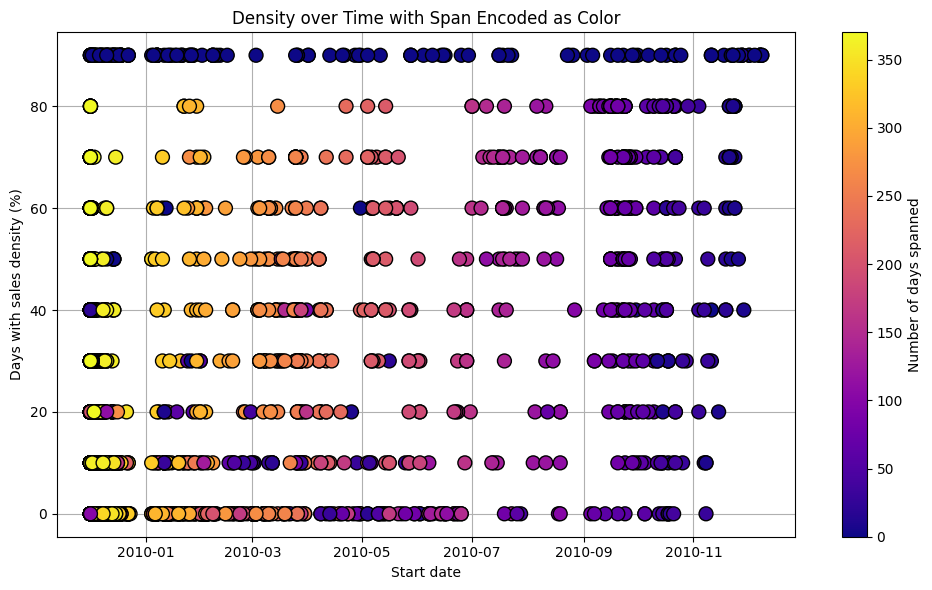

In [29]:
start_date = info_by_fuzzed_description['MinDate'].values
density_bin = (info_by_fuzzed_description['DaysWithSalesDensity'].values // 0.10) * 0.10 * 100
num_days_spanned_bin = (info_by_fuzzed_description['NumDaysSpanned'] // 10) * 10

fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and an axes

sc = ax.scatter(
    start_date, 
    density_bin, 
    c=num_days_spanned_bin, 
    cmap='plasma', 
    s=100,
    edgecolor='k'
)

# Add colorbar linked to the scatter plot
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Number of days spanned')

# Set labels and title
ax.set_xlabel('Start date')
ax.set_ylabel('Days with sales density (%)')
ax.set_title('Density over Time with Span Encoded as Color')
ax.grid(True)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

In [32]:
products_to_keep = info_by_fuzzed_description.query('NumDaysWithSales >= 180 and DaysWithSalesDensity >= 0.60').index.values
products_to_keep

array(['12 pencils small tube red spotty', '12 pencils tall tube posy',
       '12 pencils tall tube woodland', '3 stripey mice feltcraft',
       '6 ribbons rustic charm', '60 teatime fairy cake cases',
       '72 sweetheart fairy cake cases',
       'airline bag vintage jet set red',
       'antique silver tea glass etched', 'assorted colour bird ornament',
       'bag 500g swirly marbles', 'baking set 9 piece retrospot',
       'baking set spaceboy design', 'bathroom metal sign',
       'beware of the cat metal sign', 'blue happy birthday bunting',
       'blue spotty cup', 'box of 24 cocktail parasols',
       'ceramic cake bowl hanging cakes',
       'ceramic cake design spotted mug', 'charlotte bag pinkwhite spots',
       'charlotte bag suki design', 'childs apron spaceboy design',
       'chocolate this way metal sign',
       'colour glass tlight holder hanging', 'cook with wine metal sign',
       'cream cupid hearts coat hanger', 'cream heart card holder',
       'door mat 3

In [37]:
mask = info_by_fuzzed_description.index.isin(products_to_keep)

products_to_keep_info = info_by_fuzzed_description[mask]
products_to_exclude_info = info_by_fuzzed_description[~mask]

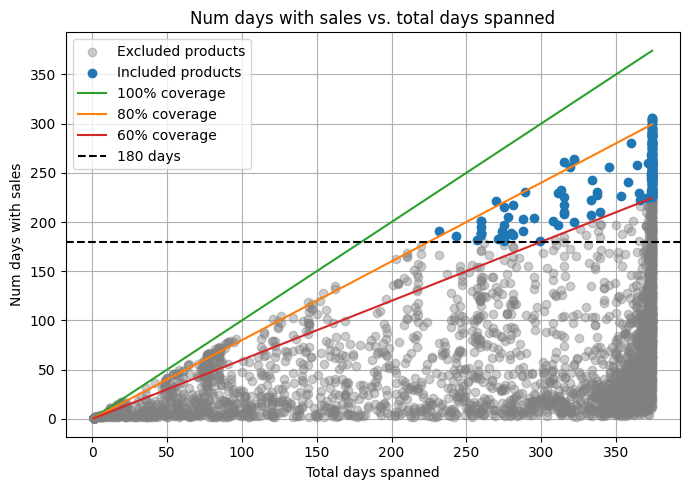

In [64]:
x = np.linspace(
    min(products_to_keep_info['NumDaysSpanned'].min(), products_to_exclude_info['NumDaysSpanned'].min()),
    max(products_to_keep_info['NumDaysSpanned'].max(), products_to_exclude_info['NumDaysSpanned'].max()),
    100
)

fig, ax = plt.subplots(figsize=(7,5))

ax.scatter(
    products_to_exclude_info['NumDaysSpanned'],
    products_to_exclude_info['NumDaysWithSales'],
    color='grey',
    alpha=0.4,
    label='Excluded products'
)

ax.scatter(
    products_to_keep_info['NumDaysSpanned'],
    products_to_keep_info['NumDaysWithSales'],
    color='tab:blue',
    alpha=1,
    label='Included products'
)

ax.plot(x, x, color='tab:green', label='100% coverage')
ax.plot(x, 0.8 * x, color='tab:orange', label='80% coverage')
ax.plot(x, 0.6 * x, color='tab:red', label='60% coverage')

ax.axhline(180, color='black', linestyle='--', label='180 days')

ax.set_title('Num days with sales vs. total days spanned')
ax.set_xlabel('Total days spanned')
ax.set_ylabel('Num days with sales')
ax.grid(True, which='both')
ax.set_axisbelow(True)
ax.legend()

plt.tight_layout()
plt.show()

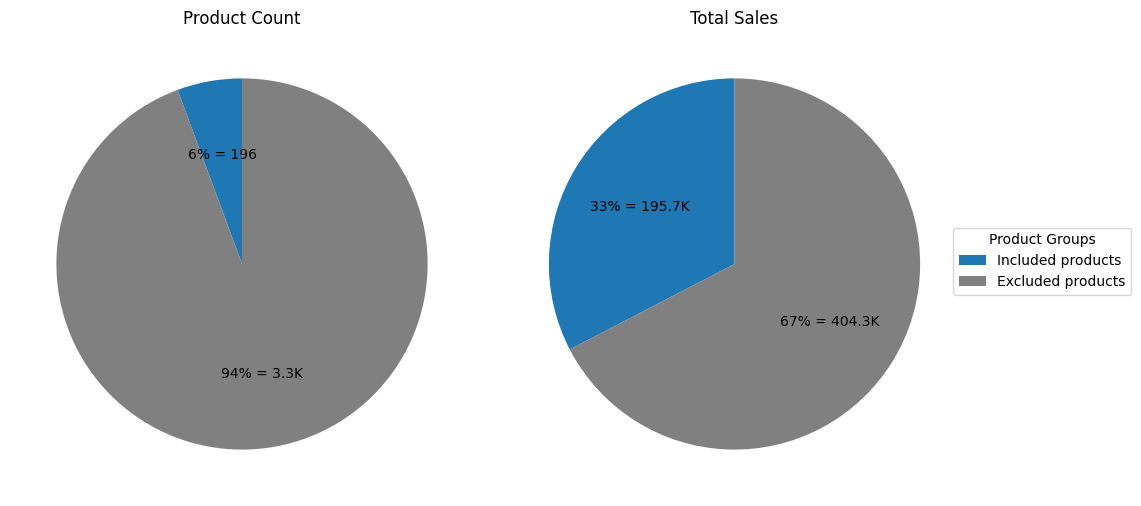

In [81]:
products_to_keep_count = len(products_to_keep_info.index)
products_to_exclude_count = len(products_to_exclude_info.index)

products_to_keep_total_sales = products_to_keep_info['TotalSold'].sum()
products_to_exclude_total_sales = products_to_exclude_info['TotalSold'].sum()

count_data = [products_to_keep_count, products_to_exclude_count]
sales_data = [products_to_keep_total_sales, products_to_exclude_total_sales]
labels = ['Included products', 'Excluded products']
colors = ['tab:blue', 'grey']  # Customize your slice colors here

def format_value(val):
    if val >= 10_000:
        return f"{val/10_000:.1f}".rstrip('0').rstrip('.') + 'K'
    elif val >= 1000:
        return f"{val/1000:.1f}".rstrip('0').rstrip('.') + 'K'
    else:
        return str(round(val))

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = pct * total / 100.0
        return f'{pct:.0f}% = {format_value(val)}'
    return my_autopct

# Plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# First pie: product count
wedges1, _, _ = axs[0].pie(
    count_data,
    autopct=make_autopct(count_data),
    startangle=90,
    colors=colors
)
axs[0].set_title("Product Count")

# Second pie: total sales
wedges2, _, _ = axs[1].pie(
    sales_data,
    autopct=make_autopct(sales_data),
    startangle=90,
    colors=colors
)
axs[1].set_title("Total Sales")

# Shared legend
fig.legend(wedges1, labels, title="Product Groups", loc="center right", bbox_to_anchor=(1.15, 0.5))
plt.tight_layout()
plt.show()

## Save data